In [ ]:
#!pip install tensorflow
#!pip install pedalboard

In [1]:
# TO USE: 
#    1. Upload your input and output wav files to the current directory in Colab
#    2. Edit the USER INPUTS section to point to your wav files, and choose a
#         model name, and number of epochs for training. 
#    3. Run each section of code. The trained models and output wav files will be 
#         added to the "models" directory.
#
#     Note: Tested on CPU and GPU runtimes.
#     Note: Uses MSE for loss calculation instead of Error to Signal with Pre-emphasis filter

#import soundfile as sf
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import clear_session
#from tensorflow.keras.activations import tanh, elu, relu
#from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
#import math
import h5py
import librosa
from pedalboard import (
    Pedalboard,
    Convolution,
    Compressor,
    Chorus,
    Distortion,
    Gain,
    Reverb,
    Limiter,
    LadderFilter,
    Phaser,
)

In [2]:
# EDIT THIS SECTION FOR USER INPUTS
#

name = 'Chorus_Test'

'''
in_file = 'data/ts9_test1_in_FP32.wav'
out_file = 'data/ts9_test1_out_FP32.wav'
epochs = 1

train_mode = 0     # 0 = speed training, 
                   # 1 = accuracy training 
                   # 2 = extended training

input_size = 150 

if not os.path.exists('models/'+name):
    os.makedirs('models/'+name)
else:
    print("A model with the same name already exists. Please choose a new name.")
    exit
'''

'\nin_file = \'data/ts9_test1_in_FP32.wav\'\nout_file = \'data/ts9_test1_out_FP32.wav\'\nepochs = 1\n\ntrain_mode = 0     # 0 = speed training, \n                   # 1 = accuracy training \n                   # 2 = extended training\n\ninput_size = 150 \n\nif not os.path.exists(\'models/\'+name):\n    os.makedirs(\'models/\'+name)\nelse:\n    print("A model with the same name already exists. Please choose a new name.")\n    exit\n'

In [3]:
fs = 44100

class WindowArray(Sequence):
        
    def __init__(self, x, y, window_len, batch_size=32):
        self.x = x
        self.y = y[window_len-1:] 
        self.window_len = window_len
        self.batch_size = batch_size
        
    def __len__(self):
        l = len(self.x)
        #return (len(self.x[0]) - self.window_len +1) // self.batch_size
        return (len(self.x) - self.window_len +1) // self.batch_size
    
    def __getitem__(self, index):
        x_out = np.stack([self.x[idx: idx+self.window_len] for idx in range(index*self.batch_size, (index+1)*self.batch_size)])
        y_out = self.y[index*self.batch_size:(index+1)*self.batch_size]
        return x_out, y_out

def pre_emphasis_filter(x, coeff=0.95):
    return tf.concat([x, x - coeff * x], 1)
    
def error_to_signal(y_true, y_pred): 
    """
    Error to signal ratio with pre-emphasis filter:
    """
    y_true, y_pred = pre_emphasis_filter(y_true), pre_emphasis_filter(y_pred)
    return K.sum(tf.pow(y_true - y_pred, 2), axis=0) / (K.sum(tf.pow(y_true, 2), axis=0) + 1e-10)
    
def save_wav(name, data):
    wavfile.write(name, fs, data.flatten().astype(np.float32))

# normalize data to loudest signal
def normalize(data):
    data_max = max(data)
    data_min = min(data)
    data_norm = max(data_max,abs(data_min))
    return data / data_norm

# add fadeout with length samples   
def apply_fadeout(audio, length):
    # convert to audio indices (samples)
    #length = int(duration*sr)
    end = len(audio)
    start = end - length

    # compute fade out curve
    # linear fade
    fade_curve = np.linspace(1.0, 0.0, length)
    audio[start:end] = audio[start:end] *fade_curve
    return audio

In [71]:
### Simpler Form of WindowArray

class ShwindowArray(Sequence):
    def __init__(self, x, y, input_size=1000):
        self.x = x
        self.y = y
        self.input_size = input_size
        
    def __len__(self):
        l = len(self.x)
        m = len(self.y)
        if l != m:
            print('Hey!')
        return l
    
    def __getitem__(self, index):
        x_out = self.x[index]
        y_out = self.y[index]
        return x_out, y_out

In [ ]:
# loads guitar signals, cuts them to 1 sec and rewrties them with fade out and normalized
# has been done already
'''
for input in range(1, 101, 1):
    x, samplerate = librosa.load('Trial_Data/GuitSigClean_Monophon/Monophon (%d).wav' %input, mono=True, sr=fs, duration=1.0, dtype=np.float32)          
    x = apply_fadeout(normalize(x),100)
    save_wav('Trial_Data/GuitSigClean_1/Monophon_1sec_(%d).wav' %(input), x)
    #with sf.SoundFile('Trial_Data/GuitSigClean_1/Monophon_1sec_(%d).wav' %(input), 'w', samplerate=fs, channels=len(x.shape)) as f:
    #    f.write(x)

x_test, ssmp = librosa.load('Trial_Data/GuitSigClean_1/Monophon_1sec_(1).wav', sr=44100, dtype=np.float32)
print(type(x_test))
'''

In [4]:
# writing pedalboard processed audio sorted by effect type
# reading processed audio and append to dry and wet array
fx_list = [Chorus(), Phaser(), Distortion()]
fx_names = ['Chorus', 'Phaser', 'Distortion']
dry = []
wet = []
effect_indices = []
for fx in range(0, 3, 1): # 0 = Chorus, 1 = Phaser, 2 = Distortion
    board = Pedalboard([fx_list[fx]], sample_rate=fs)
    for input in range(1, 101, 1):
        x, samplerate = librosa.load('Trial_Data//GuitSigClean_1/Monophon_1sec_(%d).wav' %input, mono=True, sr=fs, duration=1.0, dtype=np.float32)
        x = apply_fadeout(normalize(x),100)
        output = board(x)
        output = apply_fadeout(output, 100)
        dry.append(x)
        wet.append(output)
        effect_indices.append(fx)
        #save_wav('Trial_Data/GuitSig_with_%s/Monophon_with_%s (%d).wav' %(fx_names[fx],fx_names[fx],input), output)

dry = np.array(dry)
wet = np.array(wet)
effect_indices = np.array(effect_indices)
dataset_dry = tf.data.Dataset.from_tensor_slices(dry)
dataset_wet = tf.data.Dataset.from_tensor_slices(wet)
dataset_effect_indices = tf.data.Dataset.from_tensor_slices(effect_indices)
wet.shape

(300, 44100)

In [5]:
'''This is a similar Tensorflow/Keras implementation of the LSTM model from the paper:
    "Real-Time Guitar Amplifier Emulation with Deep Learning"
    https://www.mdpi.com/2076-3417/10/3/766/htm

    Uses a stack of two 1-D Convolutional layers, followed by LSTM, followed by 
    a Dense (fully connected) layer. Three preset training modes are available, 
    with further customization by editing the code. A Sequential tf.keras model 
    is implemented here.

    Note: RAM may be a limiting factor for the parameter "input_size". The wav data
      is preprocessed and stored in RAM, which improves training speed but quickly runs out
      if using a large number for "input_size".  Reduce this if you are experiencing
      RAM issues. 
    
    --training_mode=0   Speed training (default)
    --training_mode=1   Accuracy training
    --training_mode=2   Extended training (set max_epochs as desired, for example 50+)
'''

batch_size = 4 
test_size = 0.2
train_mode = 0
input_size = 100#500
epochs = 20

if train_mode == 0:         # Speed Training
    learning_rate = 0.01 
    conv1d_strides = 12    
    conv1d_filters = 16
    hidden_units = 36
elif train_mode == 1:       # Accuracy Training (~10x longer than Speed Training)
    learning_rate = 0.01 
    conv1d_strides = 4
    conv1d_filters = 36
    hidden_units= 64
else:                       # Extended Training (~60x longer than Accuracy Training)
    learning_rate = 0.0005 
    conv1d_strides = 3
    conv1d_filters = 36
    hidden_units= 96

In [7]:
# Create Sequential Model ###########################################
clear_session()
model = Sequential()
model.add(Conv1D(conv1d_filters, 12,strides=conv1d_strides, activation=None, padding='same',input_shape=(input_size,1)))
model.add(Conv1D(conv1d_filters, 12,strides=conv1d_strides, activation=None, padding='same'))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation=None))
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=[error_to_signal])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 84, 15)            195       
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 15)             2715      
                                                                 
 lstm (LSTM)                 (None, 36)                7488      
                                                                 
 dense (Dense)               (None, 1)                 37        
                                                                 
Total params: 10,435
Trainable params: 10,435
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Create Functional Model ###########################################
clear_session()
input_shape = (fs,1)
inputs = tf.keras.Input(shape=input_shape) # 1 second

conv1D_1 = Conv1D(conv1d_filters, 12,strides=conv1d_strides, activation=None, padding='same', input_shape=(input_shape), name='First_1D_Conv')(inputs)
#output_after_1st_layer = conv1D_1(inputs)
output_after_2nd_layer = Conv1D(conv1d_filters, 12,strides=conv1d_strides, activation=None, padding='same', name='Second_1D_Conv')(conv1D_1)
output_after_lstm_layer = LSTM(hidden_units, name='LSTM')(output_after_2nd_layer)

outputs = Dense(fs, activation=None, name='Output')(output_after_lstm_layer)
model_functional_api = tf.keras.Model(inputs=inputs, outputs=outputs, name="functional_model")
model_functional_api.summary()
model_functional_api.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=[error_to_signal])

Model: "functional_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 44100, 1)]        0         
                                                                 
 First_1D_Conv (Conv1D)      (None, 3675, 16)          208       
                                                                 
 Second_1D_Conv (Conv1D)     (None, 307, 16)           3088      
                                                                 
 LSTM (LSTM)                 (None, 36)                7632      
                                                                 
 Output (Dense)              (None, 44100)             1631700   
                                                                 
Total params: 1,642,628
Trainable params: 1,642,628
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Chorus ###########################################

### Custom Form for Functional Model

X_all = dry[:100].astype(np.float32)
print(X_all.shape)
X_all = X_all.reshape(len(X_all),44100, 1)
y_all = wet[:100].astype(np.float32)
y_all = y_all.reshape(len(y_all),44100, 1)
train_examples = int(len(X_all)*0.8)

xtrain, xtest, ytrain, ytest=train_test_split(X_all, y_all, test_size=0.15)

### Original form
'''
X_all = dry[:100].astype(np.float32).flatten()  
X_all = normalize(X_all).reshape(len(X_all),1)   
y_all = wet[:100].astype(np.float32).flatten() 
y_all = normalize(y_all).reshape(len(y_all),1)
train_examples = int(len(X_all)*0.8)
train_arr = WindowArray(X_all[:train_examples], y_all[:train_examples], input_size, batch_size=batch_size)
val_arr = WindowArray(X_all[train_examples:], y_all[train_examples:], input_size, batch_size=batch_size)
print(train_arr.__len__())
'''

(100, 44100)


'\nX_all = dry[:100].astype(np.float32).flatten()  \nX_all = normalize(X_all).reshape(len(X_all),1)   \ny_all = wet[:100].astype(np.float32).flatten() \ny_all = normalize(y_all).reshape(len(y_all),1)\ntrain_examples = int(len(X_all)*0.8)\ntrain_arr = WindowArray(X_all[:train_examples], y_all[:train_examples], input_size, batch_size=batch_size)\nval_arr = WindowArray(X_all[train_examples:], y_all[train_examples:], input_size, batch_size=batch_size)\nprint(train_arr.__len__())\n'

In [ ]:
# Train Sequential Model ###################################################
history = model.fit(train_arr, validation_data=val_arr, epochs=epochs, shuffle=True)    
model.save('models/'+name+'/'+name+'.h5')

# Run Prediction #################################################
print("Running prediction..")

# Get the last 20% of the wav data to run prediction and plot results
y_the_rest, y_last_part = np.split(y_all, [int(len(y_all)*.8)])
x_the_rest, x_last_part = np.split(X_all, [int(len(X_all)*.8)])
y_test = y_last_part[input_size-1:] 
test_arr = WindowArray(x_last_part, y_last_part, input_size, batch_size = batch_size)

prediction = model.predict(test_arr)

save_wav('models/'+name+'/y_pred.wav', prediction)
save_wav('models/'+name+'/x_test.wav', x_last_part)
save_wav('models/'+name+'/y_test.wav', y_test)

# 
# x_fft = np.fft.fft(x_last_part.flatten().astype(np.float32))
# y_fft = np.fft.fft(prediction.flatten().astype(np.float32))

# Add additional data to the saved model (like input_size)
filename = 'models/'+name+'/'+name+'.h5'
f = h5py.File(filename, 'a')
grp = f.create_group("info")
dset = grp.create_dataset("input_size", (1,), dtype='int16')
dset[0] = input_size
f.close()

In [13]:
# Train Functional Model ###################################################
history = model_functional_api.fit(xtrain, ytrain, epochs=epochs, verbose=1, validation_split=0.2, shuffle=True)    
model_functional_api.save('models/'+name+'/'+name+'_functional'+'.h5', overwrite=True)

# Run Prediction #################################################
print("Running prediction..")

val_loss, val_acc = model_functional_api.evaluate(xtrain, ytrain, verbose=2)
print("Loss:", val_loss, " Accuracy:", val_acc)

prediction = model_functional_api.predict(xtest)

save_wav('models/'+name+'_functional'+'/y_pred.wav', prediction)
save_wav('models/'+name+'_functional'+'/x_test.wav', xtest)
save_wav('models/'+name+'_functional'+'/y_test.wav', ytest)

# 
# x_fft = np.fft.fft(x_last_part.flatten().astype(np.float32))
# y_fft = np.fft.fft(prediction.flatten().astype(np.float32))

# Add additional data to the saved model (like input_size)
filename = 'models/'+name+'/'+name+'_functional'+'.h5'
f = h5py.File(filename, 'a')
grp = f.create_group("info")
dset = grp.create_dataset("input_size", (1,), dtype='int16')
dset[0] = input_size
f.close()

Epoch 1/20
3/3 [==============================] - 4s 617ms/step - loss: 0.0229 - error_to_signal: 1.1292 - val_loss: 0.0267 - val_error_to_signal: 1.2992
Epoch 2/20
3/3 [==============================] - 1s 251ms/step - loss: 0.0227 - error_to_signal: 1.1997 - val_loss: 0.0267 - val_error_to_signal: 1.6307
Epoch 3/20
3/3 [==============================] - 1s 255ms/step - loss: 0.0227 - error_to_signal: 1.8497 - val_loss: 0.0268 - val_error_to_signal: 1.2827
Epoch 4/20
3/3 [==============================] - 1s 257ms/step - loss: 0.0226 - error_to_signal: 2.0900 - val_loss: 0.0269 - val_error_to_signal: 5.6332
Epoch 5/20
3/3 [==============================] - 1s 267ms/step - loss: 0.0226 - error_to_signal: 10.8030 - val_loss: 0.0270 - val_error_to_signal: 10.4987
Epoch 6/20
3/3 [==============================] - 1s 268ms/step - loss: 0.0226 - error_to_signal: 16.3812 - val_loss: 0.0270 - val_error_to_signal: 18.8648
Epoch 7/20
3/3 [==============================] - 1s 247ms/step - loss: 

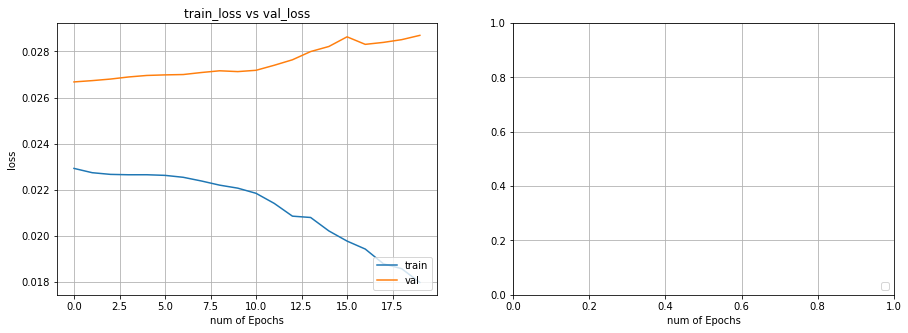

In [9]:
# visualizing losses and accuracy
train_loss, val_loss = history.history['loss'], history.history['val_loss']
#train_acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

# setup plot
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
 
# plot loss
ax[0].plot(range(epochs), train_loss)
ax[0].plot(range(epochs), val_loss)
ax[0].set_ylabel('loss')
ax[0].set_title('train_loss vs val_loss')

# plot accuracy
#ax[1].plot(range(epochs), train_acc)
#ax[1].plot(range(epochs), val_acc)
#ax[1].set_ylabel('accuracy')
#ax[1].set_title('train_acc vs val_acc')

# plot adjustement
for a in ax:
    a.grid(True)
    a.legend(['train','val'],loc=4)
    a.set_xlabel('num of Epochs')
    
plt.show()